In [112]:
import sys
import numpy as np 
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os

In [ ]:
# проверим доступ к GPU Colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('No GPU')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**1: EDA**

In [64]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [ ]:
train.shape

(12120, 6)

In [ ]:
train.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


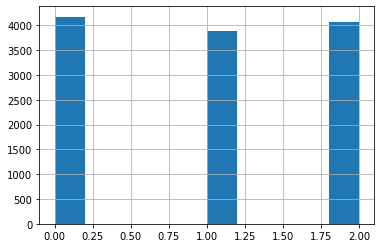

In [ ]:
train['label'].hist()

In [119]:
#посмотрим на несколько примеров
for i in range(0, 4): 
    print('PREMISE: ' + train['premise'].values[i])
    print('HYPOTHESIS: ' + train['hypothesis'].values[i])
    print('LABEL: ' + str(train['label'].values[i]))
    print(' ')

PREMISE: and these comments were considered in formulating the interim rules.
HYPOTHESIS: The rules developed in the interim were put together with these comments in mind.
LABEL: 0
 
PREMISE: These are issues that we wrestle with in practice groups of law firms, she said. 
HYPOTHESIS: Practice groups are not permitted to work on these issues.
LABEL: 2
 
PREMISE: Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
HYPOTHESIS: J'essayais d'accomplir quelque chose.
LABEL: 0
 
PREMISE: you know they can't really defend themselves like somebody grown uh say my age you know yeah
HYPOTHESIS: They can't defend themselves because of their age.
LABEL: 0
 


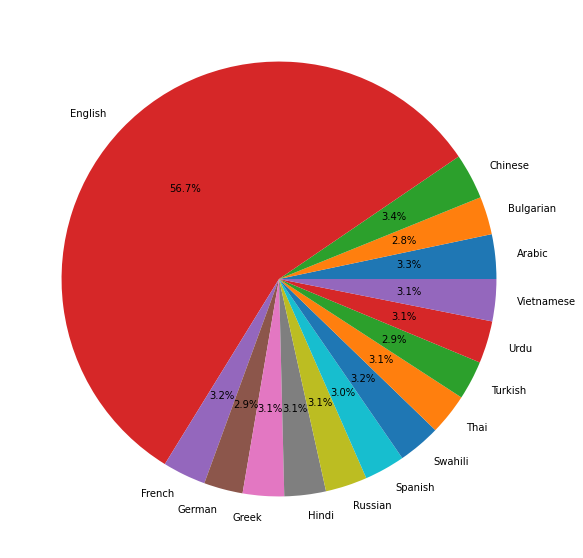

In [ ]:
# распределение языков
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00ccf69410>,
      dtype=object)

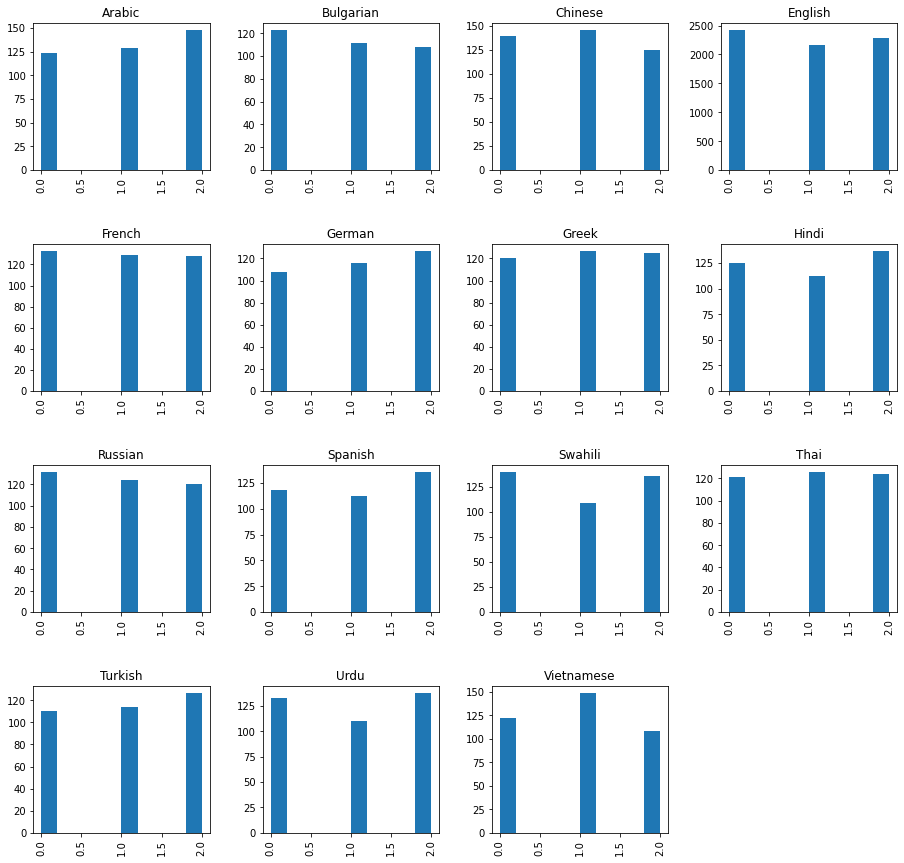

In [ ]:
#каждый лэйбл в каждом языке достаточно представлен, хотя сами языки, кроме Английского представлены довольно скудно.
train.hist(by = 'language', figsize = (15, 15))

In [120]:
train.language.value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

**2: Предобработка**
Для работы с текстом его нужно преобразовать в вектора, для этого мы будем использовать BertTokenizer, способный работать со 104 языками.

In [ ]:
model_name = 'bert-base-multilingual-cased' 
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

encode_sentence("Модель работает") 

[521, 82562, 12118, 45544, 102]

На всякий случай отмечу, что кол-во ID не совпадает с кол-вом слов, потому что модель токенезирует не по словам, а по фрагментам слов, которые образуются в результате byte pair encoding (bpe). Суть bpe в кратце - делить текст на символы и объединять наиболее частые их комбинации в своего рода морфемы и присваивать уже им ID.

In [61]:
def bert_encode(premises, hypotheses, tokenizer):
    
  num_examples = len(premises)
  
  sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
  sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

Преобразуем текст в вектора, с паддингом 0. Для начала, пусть размер векторов будет равен наиболее длинной последовательности токенов, потом посмотрим на среднюю длину последовательностей и различные перцентили и выберем оптимальный размер. Bert на вход принимает три вектора: 1) вектор c ID токенов; 2) вектор бинарная маска где 1 - на месте токена, 0 - место паддинга; 3) ещё одна бинарная маска где 0 - premise, 1 - hyperpremise.

In [62]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [ ]:
def get_avg_len(id_list):
  
  max_lens = []

  for sentence in id_list:
    current_max = 0
    for word_id in sentence:
      if word_id == 0:
        break
      current_max += 1
    max_lens.append(current_max)

  return max_lens

In [63]:
max_lens = get_avg_len(train_input['input_word_ids'])
pd_max_lens = pd.Series(max_lens)
pd_max_lens.describe()

count    12120.000000
mean        48.909983
std         23.747855
min          7.000000
25%         32.000000
50%         45.000000
75%         61.000000
max        259.000000
dtype: float64

In [ ]:
pd_max_lens.quantile(0.95)

91.0

In [43]:
train_set, val_set = train_test_split(train, test_size = 0.2)

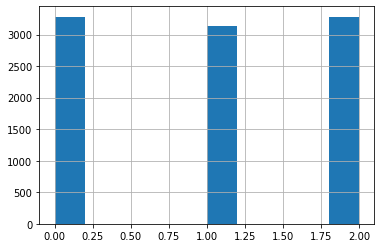

In [44]:
train_set['label'].hist()

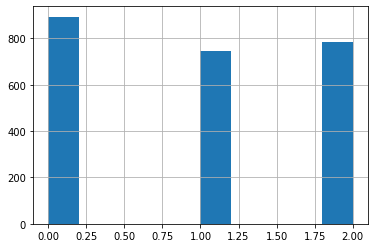

In [45]:
val_set['label'].hist()

In [65]:
max_len = 90 #выглядит как наиболее хороший вариант, примерно 1\3 от максимума, но при этом 90% всех данных в этом пределе, остальные скорее выбросы

def bert_encode_with_limit(premises, hypotheses, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
  sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=[input_word_ids.shape[0], max_len])

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=[input_word_ids.shape[0], max_len])

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=[input_word_ids.shape[0], max_len]),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [66]:
val_input = bert_encode_with_limit(val_set.premise.values, val_set.hypothesis.values, tokenizer)
train_input = bert_encode_with_limit(train_set.premise.values, train_set.hypothesis.values, tokenizer)

**3: Обучение и оценка модели**
Модель предобученная Multilingual Base Bert, которую мы дообучин на наших данных 

In [74]:
def build_model():
  
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 90)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 90)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 90)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


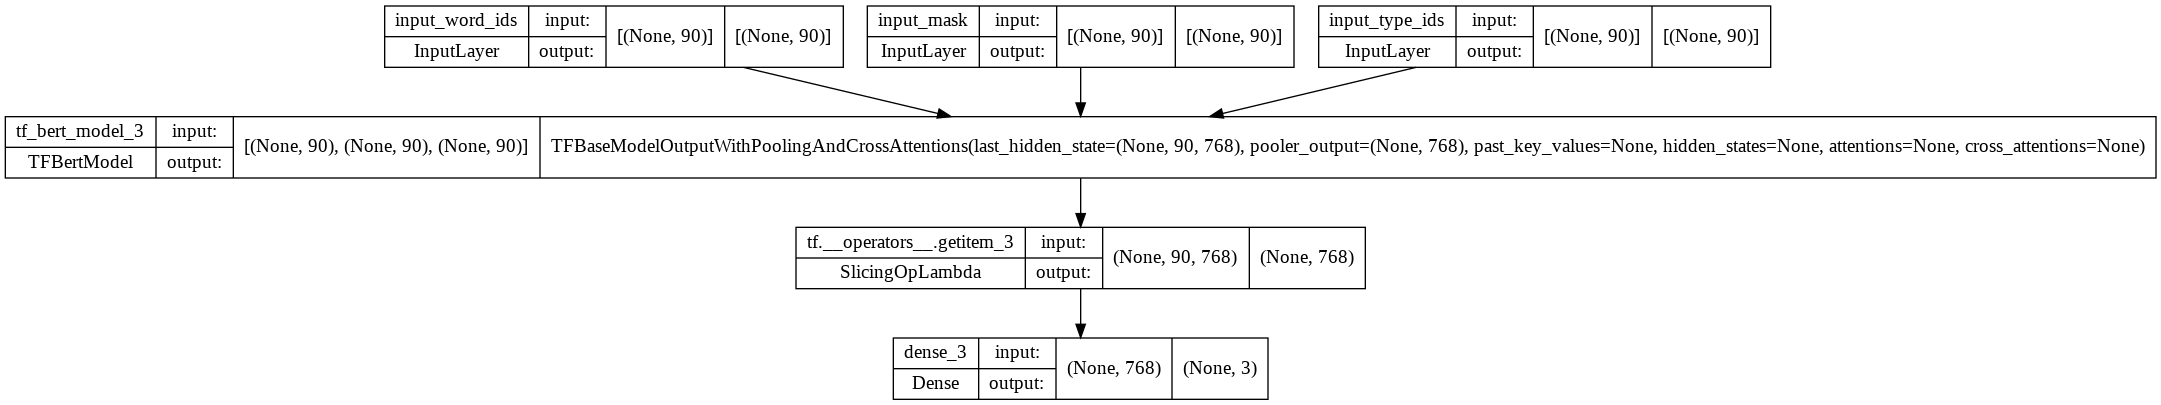

In [75]:
with tf.device('/gpu:0'):
    model = build_model()
    model.summary()
  
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [76]:
history = model.fit(train_input, train_set.label.values, epochs = 4, verbose = 1, batch_size = 64, 
                    validation_data=(val_input, val_set.label.values))

Epoch 1/4
152/152 [==============================] - 205s 1s/step - loss: 0.9849 - accuracy: 0.5010 - val_loss: 0.8637 - val_accuracy: 0.6163
Epoch 2/4
152/152 [==============================] - 185s 1s/step - loss: 0.7763 - accuracy: 0.6605 - val_loss: 0.8358 - val_accuracy: 0.6188
Epoch 3/4
152/152 [==============================] - 185s 1s/step - loss: 0.6295 - accuracy: 0.7398 - val_loss: 0.8671 - val_accuracy: 0.6374
Epoch 4/4
152/152 [==============================] - 185s 1s/step - loss: 0.4927 - accuracy: 0.8032 - val_loss: 0.9277 - val_accuracy: 0.6242


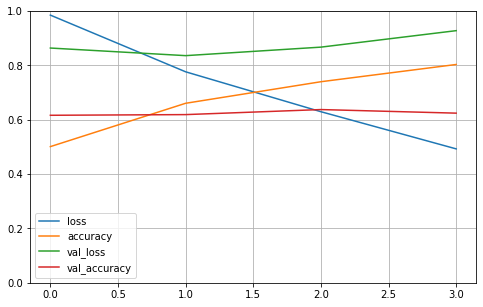

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [109]:
#посмотрим на матрицу несоответствий, чтобы лучше оценить качество модели 
y_val_proba = model.predict(val_input)
y_val_proba = np.argmax(y_val_proba, axis = 1)
conf_matrix = confusion_matrix(val_set.label.values, y_val_proba)
conf_matrix

array([[583, 133, 178],
       [125, 447, 175],
       [140, 160, 483]])

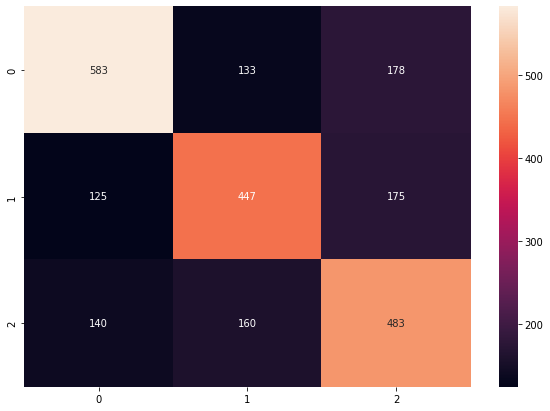

In [110]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [82]:
#стоит также посмотереть на ошибки в разных языках
val_set['preds'] = y_val_proba

In [85]:
val_set_copy = val_set.copy()

In [93]:
languages = val_set_copy.language.unique()

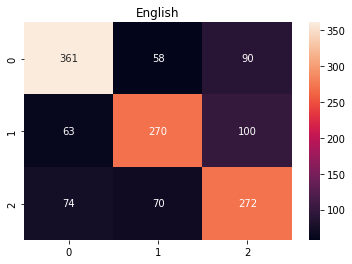

<Figure size 504x360 with 0 Axes>

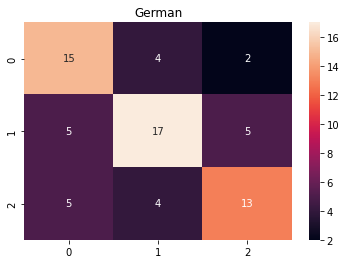

<Figure size 504x360 with 0 Axes>

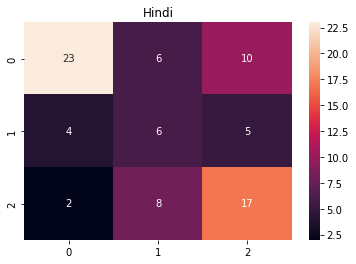

<Figure size 504x360 with 0 Axes>

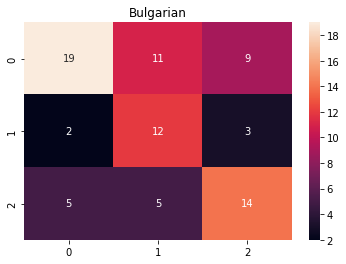

<Figure size 504x360 with 0 Axes>

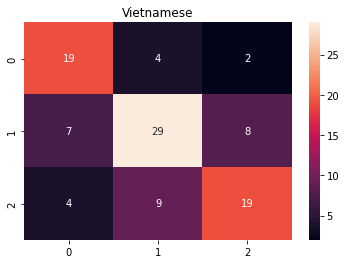

<Figure size 504x360 with 0 Axes>

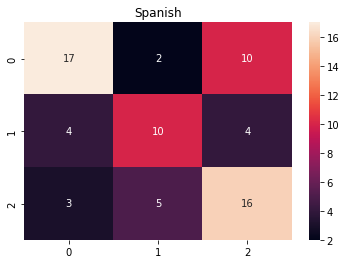

<Figure size 504x360 with 0 Axes>

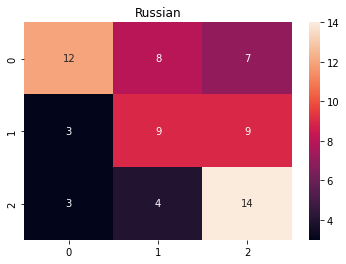

<Figure size 504x360 with 0 Axes>

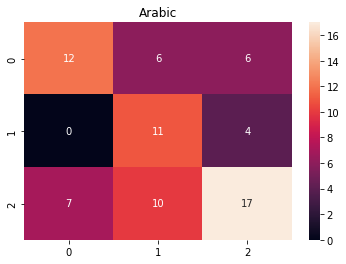

<Figure size 504x360 with 0 Axes>

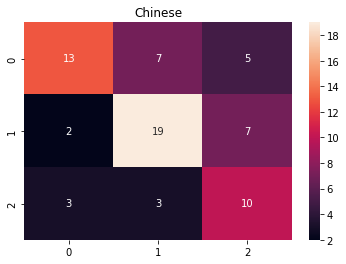

<Figure size 504x360 with 0 Axes>

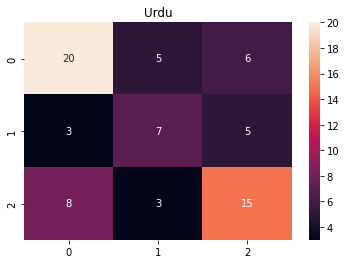

<Figure size 504x360 with 0 Axes>

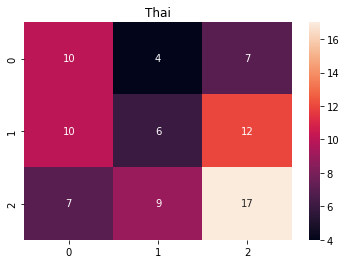

<Figure size 504x360 with 0 Axes>

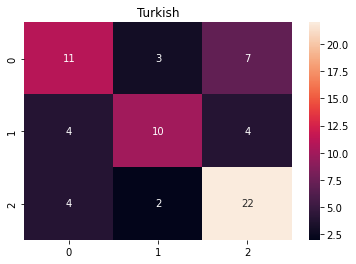

<Figure size 504x360 with 0 Axes>

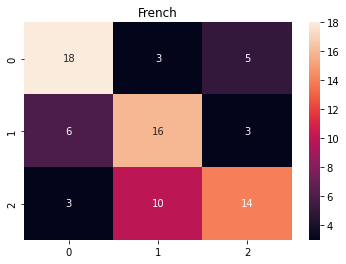

<Figure size 504x360 with 0 Axes>

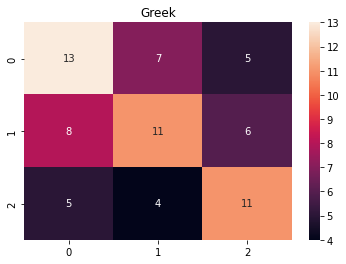

<Figure size 504x360 with 0 Axes>

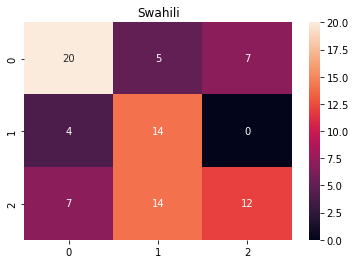

<Figure size 504x360 with 0 Axes>

In [116]:
for lang in languages:
  conf_matrix = confusion_matrix(val_set_copy.loc[val_set_copy.language == lang].label.values, 
                                 val_set_copy.loc[val_set_copy.language == lang].preds.values)
  
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
  
  ax = plt.axes()
  plt.figure(figsize = (7,5))
  sn.heatmap(df_cm, annot=True, fmt='g', ax = ax)
  ax.set_title(lang)
  plt.show()
  

Модель лучше всего справляется с предложениями на Английском языке и других языках англо-французской группы, со многими остальными у модели проблемы. Что неудивительно учитывая что в тренировочных данных всего лишь 300-400 экземпляров объекта. Оценка на тестовых данных Kaggle в read_me.